In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
import theano
import theano.tensor as T

In [3]:
#theano.config.optimizer = 'None'
#theano.config.exception_verbosity = 'high'
#theano.config.mode = 'FAST_COMPILE'

# Data generation

Generate spike trains. If the specified filename already exists, the precomputed data is used instead.

*Note*: Spike trains use relatively fine time bins (0.2&nbsp;ms). This is because spike times must be precise relative to the timescale of the PSP kernel (i.e. $τ_m$).

In [4]:
source_datalen = 10 # Use 4 seconds of data
datalen = 3.5       # Amount of data to use for likelihood
burnin = 0.5        # Amount of data to discard from likelihood
mbatch_size = 1     # Batch size when computing likelihood / gradients

In [5]:
spikemodel = main.generate_spikes(datalen,
                                  filename='data/short_adap/fsgif_{}s_sin-input'
                                           .format(source_datalen))

2017-07-10 14:19:42,433 - root - INFO - Checking for precomputed data...
2017-07-10 14:19:43,209 - root - INFO - Precomputed data found. Skipping data generation


Compute the activity trace by summing over spikes. We subsample the result because the activity trace uses a coarser time bin of 1&nbsp;ms.

*Note*: When subsampling, we average over $n$ bins and combine into one, so we aren't just throwing away 80% of our data.

In [6]:
main.compute_spike_activity(max_len=burnin+datalen)

Plot the generated data.

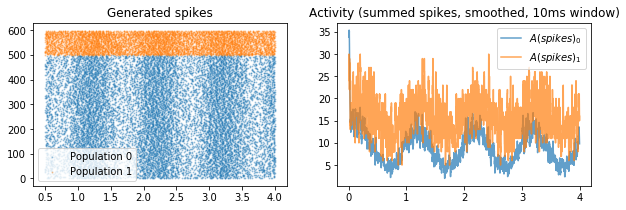

In [7]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [8]:
mbatch_size = 1
burnin_idx = int( (.5/main.mf_dt)  // mbatch_size * mbatch_size )
stop_idx = int( burnin+datalen // main.mf_dt )

In [9]:
mfmodel = main.derive_mf_model_from_spikes()

> /home/alex/Recherche/macke_lab/code/fsGIF/fsgif_model.py(765)init_populations()
-> self.θtilde_dis.set()
(Pdb) c


In [10]:
mfmodel.nbar.compute_up_to('end')
def logL_fn():
    return mfmodel.loglikelihood(burnin_idx, stop_idx-burnin_idx)[0]

In [11]:
del main.loaded['derived mf model']

In [12]:
sinn.inputs.clear()

main.load_theano()

In [13]:
main.loaded['spike activity']['Ahist'].unlock()
main.loaded['spike activity']['Ihist'].unlock()
main.loaded['spike activity']['Ahist'].theano_reset()
main.loaded['spike activity']['Ihist'].theano_reset()
main.loaded['spike activity']['Ahist'].lock()
main.loaded['spike activity']['Ihist'].lock()
try:
    mfmodelT.theano_reset()
    mfmodelT.clear_unlocked_histories()
except NameError:
    pass
mfmodelT = main.derive_mf_model_from_spikes()

2017-07-10 14:20:41,001 - root - INFO - Producing Theano mean-field model.


> /home/alex/Recherche/macke_lab/code/fsGIF/fsgif_model.py(765)init_populations()
-> # HACK θ_dis updates should not be part of the loglikelihood's computational graph
(Pdb) c


2017-07-10 14:23:52,058 - fsgif_model - INFO - Compiling advance function.
2017-07-10 14:23:52,062 - theano_shim - INFO - Clearing Theano updates
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-10 14:23:52,123 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-10 14:23:52,124 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:52,141 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-10 14:23:52,142 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:52,144 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-10 14:23:52,145

In [14]:
mfmodelT.theano_reset()
mfmodelT.clear_unlocked_histories()

2017-07-10 14:23:54,900 - theano_shim - INFO - Clearing Theano updates


# Debugging

In [ ]:
tidx = shim.getT().lscalar('tidx')

In [15]:
x = mfmodelT.nbar[tidx]
f = theano.function([tidx], x, updates=shim.get_updates())

/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-07 00:21:06,920 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-07 00:21:06,921 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,933 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-07 00:21:06,934 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,937 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-07 00:21:06,938 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,975 - theano_shim - INFO - Adding 

OrderedDict([(y data, if{}.0), (t idx (y), Elemwise{switch,no_inplace}.0), (h_tot data, if{}.0), (t idx (h_tot), Elemwise{switch,no_inplace}.0), (u data, if{}.0), (t idx (u), Elemwise{switch,no_inplace}.0), (g data, if{}.0), (t idx (g), Elemwise{switch,no_inplace}.0), (varθfree data, if{}.0), (t idx (varθfree), Elemwise{switch,no_inplace}.0), (varθ data, if{}.0), (t idx (varθ), Elemwise{switch,no_inplace}.0), (λ data, if{}.0), (t idx (λ), Elemwise{switch,no_inplace}.0), (P_λ data, if{}.0), (t idx (P_λ), Elemwise{switch,no_inplace}.0), (m data, if{}.0), (t idx (m), Elemwise{switch,no_inplace}.0), (W data, if{}.0), (t idx (W), Elemwise{switch,no_inplace}.0), (h data, if{}.0), (t idx (h), Elemwise{switch,no_inplace}.0), (λfree data, if{}.0), (t idx (λfree), Elemwise{switch,no_inplace}.0), (Pfree data, if{}.0), (t idx (Pfree), Elemwise{switch,no_inplace}.0), (x data, if{}.0), (t idx (x), Elemwise{switch,no_inplace}.0), (v data, if{}.0), (t idx (v), Elemwise{switch,no_inplace}.0), (Z data, 

In [16]:
f(0)

array([ 7.23 ,  1.451])

# Not Debugging

In [15]:
tidx = shim.getT().lscalar('tidx')
logL_graph, upds = mfmodelT.loglikelihood(tidx, mbatch_size)
logger.info("Compiling Theano loglikelihood")
logL_step = shim.gettheano().function([tidx], logL_graph,
                                      updates=upds)
logger.info("Done compilation.")
mfmodelT.theano_reset()
def logL_fnT(model):
    mfmodelT.clear_unlocked_histories()
    mfmodelT.advance(burnin_idx)
    #for i in range(0, burnin_idx, mbatch_size):
    #    logL_step(i)
    return sum(logL_step(i)
               for i in range(burnin_idx, stop_idx, mbatch_size))

2017-07-10 14:23:54,919 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-10 14:23:54,974 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-10 14:23:54,975 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:54,989 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-10 14:23:54,990 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:54,993 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-10 14:23:54,994 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwis

In [16]:
theano.printing.pprint(mfmodelT.θtilde_dis._data[:6])

'((Δu * (TensorConstant{1} - exp(((-AdvancedSubtensor1((switch(and_(TensorConstant{(788, 1) of True}, lt(TensorConstant{[[ 0.788]\n.. [ 0.001]]}, (TensorConstant{0} + MaxAndArgmax{axis=(0,)}((t_ref - TensorConstant{0}))))), Reshape{2}((TensorConstant{(788, 1) of 1.0} * height), TensorConstant{[788   2]}), fill(Reshape{2}((TensorConstant{(788, 1) of 1.0} * height), TensorConstant{[788   2]}), TensorConstant{0.0})) + switch(TensorConstant{[[False]\n ..\n [ True]]}, Reshape{2}(switch(lt(TensorConstant{[[ 0.788]\n.. [ 0.001]]}, t_ref[:, :]), TensorConstant{0}, ((J_θ / τ_θ)[:, :] * exp(((-(TensorConstant{[[ 0.788]\n.. [ 0.001]]} - t_ref[:, :])) / τ_θ[:, :])))), TensorConstant{[788   2]}), fill(Reshape{2}(switch(lt(TensorConstant{[[ 0.788]\n.. [ 0.001]]}, t_ref[:, :]), TensorConstant{0}, ((J_θ / τ_θ)[:, :] * exp(((-(TensorConstant{[[ 0.788]\n.. [ 0.001]]} - t_ref[:, :])) / τ_θ[:, :])))), TensorConstant{[788   2]}), TensorConstant{0.0})))[::int64], TensorConstant{[787 786 7..2   1   0]})) / Δ

In [17]:
print(logL_fn())
print(logL_fnT(mfmodelT))

-8933171.856438149
-8933171.85644


(0, 10)

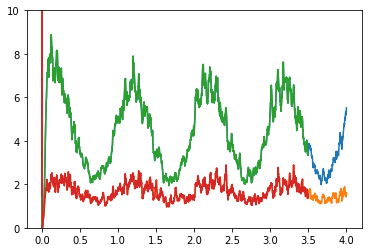

In [18]:
anlz.plot(mfmodel.nbar)
anlz.plot(mfmodelT.nbar)
plt.ylim((0, 10))

(0, 10)

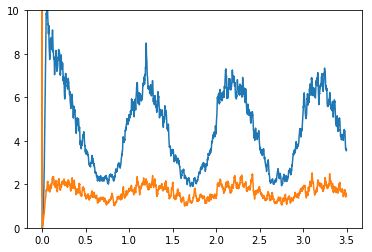

In [21]:
anlz.plot(mfmodelT.nbar)
plt.ylim((0,10))

In [52]:
mfmodel.nbar[0.004]

ShimmedShared([ 0.006,  0.003])

In [32]:
nbar = histories.DataView(mfmodelT.nbar)

In [54]:
nbar[0.004]

ShimmedShared([-0.011,  0.   ])

In [43]:
u = histories.DataView(mfmodelT.u)

In [23]:
varθ = histories.DataView(mfmodelT.varθ)

In [24]:
mfmodel.varθ[0.002]

ShimmedShared([[    inf,     inf],
               [    inf,     inf],
               [    inf,     inf],
               ..., 
               [ 15.101,  15.   ],
               [ 15.1  ,  15.   ],
               [ 15.   ,  15.   ]])

In [25]:
varθ[0.002]

array([[ 15.,  15.],
       [ 15.,  15.],
       [ 15.,  15.],
       ..., 
       [ 15.,  15.],
       [ 15.,  15.],
       [ 15.,  15.]])

In [82]:
abs(mfmodel.varθ[0.004].get_value() - varθ[0.004]).max()

inf

In [27]:
mfmodelT.θtilde_dis._data[:6].eval()

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [26]:
theano.printing.pprint(mfmodelT.θtilde_dis._data[:6])

'θtilde_dis data[:int64]'

In [10]:
tidx = shim.getT().lscalar('tidx')
logL_graph, upds = mfmodelT.loglikelihood(tidx, mbatch_size)

2017-07-07 14:35:50,680 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-07 14:35:50,743 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-07 14:35:50,745 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-07 14:35:50,760 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-07 14:35:50,762 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-07 14:35:50,765 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-07 14:35:50,766 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwis

In [14]:
ggraph = T.grad(logL_graph, mfmodelT.params.w)

In [15]:
g = theano.function([tidx], ggraph)

In [17]:
g(2)

array([[ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
logL_step(burnin_idx)

In [23]:
mfmodel.loglikelihood(burnin_idx, mbatch_size)[0]

ShimmedShared(-8953.556386109334)

In [25]:
mfmodel.loglikelihood(burnin_idx, 1)[0] + mfmodel.loglikelihood(burnin_idx+1, 1)[0]

ShimmedShared(-11940.789625753345)

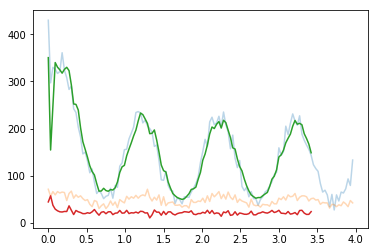

In [18]:
anlz.plot(mfmodelT.n, alpha=0.3)
anlz.plot(mfmodelT.nbar)

# Gradient descent

In [12]:
# Clamp parameters: only parameters whose mask is set to True are fit
fitmask = {mfmodelT.params.c: False,
           mfmodelT.params.w: np.array([[True, False],
                                     [False, False]]),
           mfmodelT.params.τ_m: np.array([False, True])}

In [13]:
sgd = gd.SGD(mfmodelT.loglikelihood,
             optimizer = 'adam',
             model = mfmodelT,
             burnin = burnin,
             datalen = datalen,
             mbatch_size = mbatch_size)

In [14]:
sgd.transform( mfmodelT.params.τ_m, 'logτ_m',
               lambda τ: shim.log10(τ), lambda logτ: 10**logτ )

2017-07-08 16:12:43,002 - theano_shim - INFO - Clearing Theano updates
2017-07-08 16:12:43,008 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-08 16:12:43,056 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-08 16:12:43,057 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-08 16:12:43,071 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-08 16:12:43,072 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-08 16:12:43,074 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-08 16:12:

In [15]:
sgd.compile( fitparams = fitmask, 
             lr = 0.01
           )

2017-07-08 16:12:43,283 - theano_shim - INFO - Clearing Theano updates
2017-07-08 16:12:43,288 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-07-08 16:12:43,288 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-08 16:12:43,337 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-08 16:12:43,338 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-08 16:12:43,350 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-08 16:12:43,351 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}

In [16]:
sgd.set_ground_truth(mfmodelT.params)

evols = []

In [39]:
sgd.iterate(Nmax=5e4)

2017-07-08 21:48:22,590 - sinn.optimize.gradient_descent - INFO - Iteration 62586 – <log L> = -2978.83
2017-07-08 21:48:22,591 - sinn.optimize.gradient_descent - INFO - Cost/likelihood evaluation : 17767.4s / 14262.7s (124.6% total execution time)
2017-07-08 21:48:22,592 - sinn.optimize.gradient_descent - INFO - Time per iteration: 227.889ms


Did not converge.


In [20]:
mfmodelT.params.w.get_value()

array([[ 0.176, -0.702],
       [ 0.176, -0.702]])

In [40]:
mfmodelT.params.w.get_value()

array([[ 0.792, -0.702],
       [ 0.176, -0.702]])

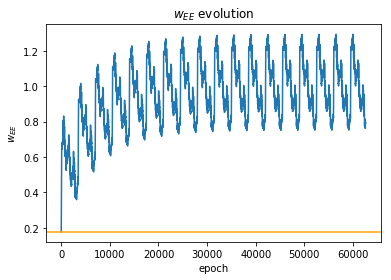

In [83]:
plt.title('$w_{EE}$ evolution')
plt.plot(sgd.get_evol()['w'][:,0,0])
plt.xlabel("epoch")
plt.ylabel("$w_{EE}$")
plt.axhline(0.176, color='orange')

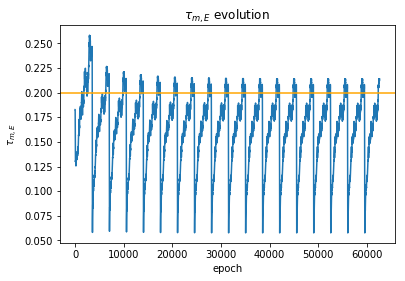

In [85]:
plt.title('$τ_{m,E}$ evolution')
plt.plot(np.exp(sgd.get_evol()['logτ_m'][:,1]))
plt.xlabel('epoch')
plt.ylabel('$τ_{m,E}$')
plt.axhline(0.2, color='orange')

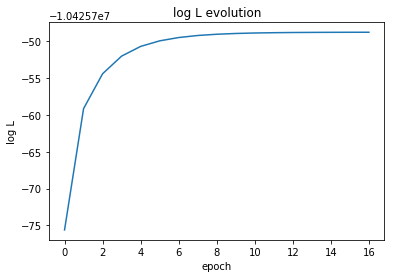

In [84]:
plt.title("log L evolution")
plt.plot(sgd.get_evol()['logL'][1:])
plt.xlabel("epoch")
plt.ylabel("log L")

In [49]:
io.save("data/sgd_data.sin", (sgd.tot_time, sgd.cum_step_time, sgd.get_evol()))

'/home/alex/Recherche/macke_lab/code/fsGIF/data/sgd_data.sin'

In [50]:
tot_time, cum_step_time, evol = io.load("data/sgd_data.sin")

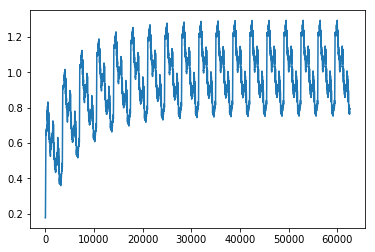

In [57]:
plt.plot(evol['w'][:,0,0])

In [ ]:
plt.plot(evol[''][:,0,0])

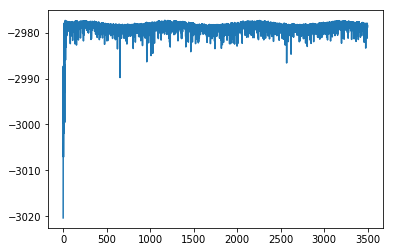

In [43]:
plt.plot(sgd.step_cost)

In [71]:
import os.path
basedir = os.path.expanduser('~/Recherche/macke_lab/code/fsGIF/data/short_adap/')
filename_base = basedir + "fsgif_{}s_sin-input_likelihood_theano"
filename = filename_base.format(4)

In [72]:
logL = HeatMap.from_raw(io.loadraw(filename))

In [73]:
evol = {'w': sgd.get_evol()['w'][:,0,0],
        'τ_m': sgd.get_evol()['τ_m'][:,1]}

KeyError: 'τ_m'

In [74]:
sgd.get_evol().keys()

dict_keys(['c', 'logτ_m', 'w', 'logL'])

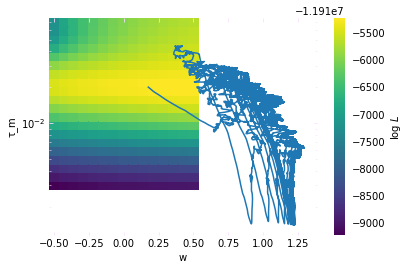

In [76]:
anlz.plot(logL)
sgd.plot_param_evol_overlay(logL)

## New machine
First number: gradient evaluation <br>
Second number: likelihood evaluation

In [15]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

4.71606696099916
0.2595898110012058


## Old Power Mac
First number: gradient evaluation<br>
Second number: likelihood evaluation

In [14]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

29.315469363494778
0.36129934259224683


In [12]:
sgd.iterate(Nmax=1e3)

KeyboardInterrupt: 

In [13]:
sgd.step_i

0

In [11]:
logL_fn = theano.function([], logL_graph)

In [15]:
theano.printing.pydotprint(logL_fn, outfile="logL_pydot.png", scan_graphs=True)

The output file is available at logL_pydot_scan_fn_162.png
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.827805 to fit

The output file is available at logL_pydot.png


In [13]:
logL_fn()

[array(-29679.126253179962)]

In [6]:
mfmodel = main.derive_mf_model_from_spikes()
gradlogL = main.compile_theano_gradloglikelihood2(mfmodel.params.w)

2017-06-27 21:55:47,167 - root - INFO - Producing Theano mean-field model.
2017-06-27 21:56:20,749 - theano_shim - INFO - Adding Theano update : θ_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,750 - theano_shim - INFO - Adding Theano update : t idx (θ_dis) -> Elemwise{switch,no_inplace}.0
/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-27 21:56:20,757 - theano_shim - INFO - Adding Theano update : θtilde_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,758 - theano_shim - INFO - Adding Theano update : t idx (θtilde_dis) -> Elemwise{switch,no_inplace}.0
2017-06-27 21:56:21,287 - root - INFO - Theano model complete.
2017-06-27 21:56:21,288 - root - INFO - Produc

In [7]:
gradlogL(0.5, 3.4)

2017-06-27 21:57:12,656 - root - INFO - Computing loglikelihood gradient.
2017-06-27 21:57:48,860 - root - INFO - Done.


array([[-27.418,  -5.134],
       [ 18.957,   8.997]])

Create the activity model we will fit, with activity trace and input constrained by the spike data.

# Visual validation

To check that the models are consistent, we instantiate a second mean-field model with the same input but let it compute the activity trace. We check that the trace it produces is consistent with the one we will fit to.

In [6]:
mfmodel_unconstrained = main.init_mean_field_model(activity_history = None,
                                                   input_history = Ihist,
                                                   model_params = mfmodel.params)

mfmodel_unconstrained.A.name = 'A (mf)'

In [7]:
mfmodel_unconstrained.A.set()  # Compute A

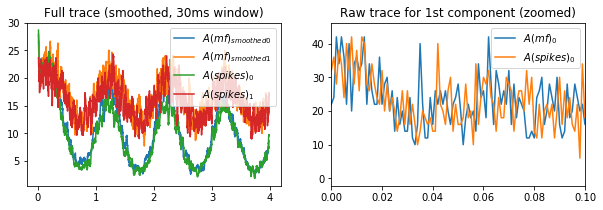

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Full trace (smoothed, 30ms window)")
anlz.plot(anlz.smooth(mfmodel_unconstrained.A, 30))
anlz.plot(anlz.smooth(Ahist, 30), label='A (spikes)')
plt.legend()

plt.subplot(1,2,2)
plt.title("Raw trace for 1st component (zoomed)")
anlz.plot(mfmodel_unconstrained.A, component=0)
anlz.plot(Ahist, label='A (spikes)', component=0)
plt.legend()
plt.xlim((0.0, 0.1))

None

# Likelihood sweep

In [14]:
# Workaround for issue with `sinn`
spikemodel.λ.name = 'spikeλ'
spikemodel.u.name = 'spikeu'

histnames_to_delete = ['A_subsampled_by_5_smoothed']
dellist = []
for h in mfmodel.history_inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del mfmodel.history_inputs[h]
    
dellist = []
for h in sinn.inputs:
    if h.name in histnames_to_delete:
        dellist.append(h)
for h in dellist:
    del sinn.inputs[h]

In [15]:
tidx = shim.getT().scalar('tidx', dtype='int32')
output_res_idx = mfmodel.nbar[tidx]

/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-24 23:43:59,255 - theano_shim - INFO - Adding Theano update : A_Δ data -> IncSubtensor{Set;int64:int64:}.0
2017-06-24 23:43:59,255 - theano_shim - INFO - Adding Theano update : t idx (A_Δ) -> Elemwise{switch,no_inplace}.0
2017-06-24 23:43:59,271 - theano_shim - INFO - Adding Theano update : y data -> IncSubtensor{Set;int64}.0
2017-06-24 23:43:59,272 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-06-24 23:43:59,283 - theano_shim - INFO - Adding Theano update : h_tot data -> IncSubtensor{Set;int64}.0
2017-06-24 23:43:59,284 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,

In [16]:
f = theano.function([tidx], updates=shim.cf.theano_updates)

In [17]:
mfmodel.theano_reset()

2017-06-24 23:44:00,473 - theano_shim - INFO - Clearing Theano updates


In [18]:
for i in range(3999):
    f(i)

In [19]:
mfmodel.nbar.lock()

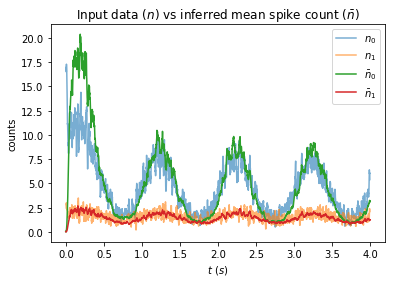

In [31]:
plt.title("Input data ($n$) vs inferred mean spike count ($\\bar{n}$)")
anlz.plot(anlz.smooth(mfmodel.n, 10), alpha=0.6, label="n")
anlz.plot(mfmodel.nbar, label="\\bar{n}")
plt.ylabel("counts")
plt.xlabel("$t$ ($s$)")
plt.legend()

In [27]:
mfmodel.n._original_data.get_value()[201:210]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
%debug

> /home/alex/Recherche/macke_lab/code/sinn/sinn/histories.py(2699)set()
   2697                     raise ValueError("[Series.set] The given source series does not match the dimensions of this one.\n"
   2698                                      "Source shape: {}\nThis history's shape: {}."
-> 2699                                      .format(source.shape, tarr.shape + self.shape))
   2700                 data = source
   2701 

ipdb> up
> /home/alex/Recherche/macke_lab/code/sinn/sinn/analyze/analyze.py(215)smooth()
    213         res.pad(series.t0idx, len(series._tarr) - len(series) - series.t0idx)
    214             # Add the same amount of padding as series
--> 215         res.set(_running_mean(series[:], amount))
    216 
    217         return res

ipdb> series
ipdb> series.hist
ipdb> series.t0idx
101
ipdb> series[:].shape
(3999, 2)
ipdb> series.hist[:].shape
Shape.0
ipdb> series.hist[:].eval().shape
(4100, 2)
ipdb> series.hist.get_t_idx(slice(None, None))
slice(101, 4100, None)

In [53]:
anlz.analyze._running_mean(ndata, 10)

RuntimeError: The update function for history n data is not set.

In [42]:
arr = mfmodel.n._data.eval()
ndata = Series(name='n data', t0=0, tn=len(arr)-1, dt=1, shape=arr.shape[1:])
ndata.set(arr)

In [44]:
mfmodel.n.use_theano

False

In [34]:
mfmodel.n.t0idx

101

In [24]:
mfmodel.n._cur_tidx.eval()

array(4200)

In [20]:
list(shim.cf.theano_updates)[10].get_value()

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [24]:
list(shim.cf.theano_updates)[0].get_value().max()

0.0

In [15]:
main.likelihood_sweep(('w', (0,0)), ('τ_m', (0,)),
                      fineness = (10,2),
                      mean_field_model = mfmodel,
                      output_filename = 'fsgif_loglikelihood_{}s_sin-input_theano.dat'
                                        .format(datalen),
                      recalculate = False)

2017-06-19 13:22:59,107 - root - INFO - Computing log likelihood...
2017-06-19 13:22:59,110 - sinn.sweep - INFO - Evaluating sweep at [-0.5, 0.0030000000000000009]
2017-06-19 13:23:03,109 - sinn.sweep - INFO - Evaluating likelihood function.
2017-06-19 13:23:03,111 - theano_shim - INFO - Clearing Theano updates
/home/rene/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


RecursionError: maximum recursion depth exceeded while calling a Python object

In [17]:
mfmodel.u._cur_tidx.get_value()

array(0)

In [30]:
mfmodel.A_Δ._is_batch_computable()

True

In [18]:
[h.name for h in sinn.inputs if not h._is_batch_computable()]

['Y', 'P_λ', 'v', 'P_Λ', 'p', 'nbar', 'W']

In [17]:
[h._is_batch_computable() for h in sinn.inputs]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True]

In [21]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['Pfree', 'P_Λ', 'x', 'X', 'W']

In [22]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, True, True, False]

In [23]:
[h.name for h in sinn.inputs[mfmodel.Pfree]]

['Pfree', 'λfree']

In [43]:
sinn.inputs[mfmodel.p]

AttributeError: 'GIF_mean_field' object has no attribute 'p'

In [47]:
[h.name for h in sinn.inputs[mfmodel.nbar]]

['X', 'Pfree', 'x', 'W', 'P_Λ']

In [49]:
[h._is_batch_computable() for h in sinn.inputs[mfmodel.nbar]]

[False, False, False, False, False]

In [51]:
[h.name for h in sinn.inputs[mfmodel.X]]

['m']

In [53]:
mfmodel.m._is_batch_computable()

False

In [54]:
[h.name for h in sinn.inputs[mfmodel.m]]

['P_λ', 'm']

In [56]:
mfmodel.θtilde_dis._is_batch_computable()

True

Below we plot the unnormalized likelihood. True parameters have non-zero probability (~5x less then the MLE).

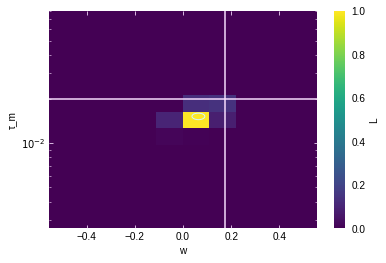

In [10]:
main.plot_likelihood('fsgif_loglikelihood_{}s_sin-input.dat'.format(datalen),
                     ellipse=None,
                     true_params=(true_params.w[0][0],
                                  true_params.τ_m[0]),
                     recalculate=True)

# Model equations

## Spiking model

\begin{gather}
u_{l, i} = \begin{cases}
u_{l-1, i} e^{-Δt/τ_m} + \bigl[u_{rest}^{α(i)} + R I_{ext}^{α(i)}(l) + R I_{syn, i}(l) \bigr]  (1 - e^{-Δt/τ_m}) & \text{if $\hat{t}_i \geq t_{ref}^{α(i)}$} \\
u_{rest}^{α(i)} & \text{otherwise}
\end{cases}
\end{gather}